In [1]:
import matplotlib.pyplot as plt
from os import path, listdir
import os
from monai.data import (Dataset, list_data_collate, DataLoader, decollate_batch, PersistentDataset)
from monai.transforms import (
    LoadImaged,
    Compose,
    MapTransform,
    Orientationd,
    ToMetaTensord,  # ? same as ensuretyped?
    EnsureChannelFirstd,
    NormalizeIntensityd,
    Spacingd,
    RandCropByPosNegLabeld,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    Activations,
    AsDiscrete,
)

from monai.networks.nets import  UNet
from monai.losses import  DiceCELoss, DiceFocalLoss, GeneralizedDiceFocalLoss
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.optimizers import Novograd, WarmupCosineSchedule

from torch.utils.tensorboard import SummaryWriter

import torch

from tqdm import tqdm

c:\Users\ibrah\miniconda3\envs\fyp\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

def encode_lgg_hgg(x):
    """Encode LGG and HGG as 0 and 1 for stratification

    Args:
        x (str): LGG or HGG in Dataframe

    Returns:
        int: encodes 0 for LGG and 1 for HGG
    """
    return 0 if x == "LGG" else 1


def train_val_test_dataset(data_path: str):
    """From 100% Cases take 20% cases as Validation.
    Take the remaining 80% cases as training

    Stratification done on data to ensure that the classes are balanced.

    Args:
        data_path (str, optional): Path to Name Mapping File provided by BraTS.

    Returns:
        training, validation, testing: list of case names split into training, validation and testing.
    """
    data = pd.read_csv(data_path)
    data = data[["Grade", "BraTS_2020_subject_ID"]]
    data.Grade = data["Grade"].map(encode_lgg_hgg)
    (training, validation, train_check, val_check,) = train_test_split(
        data.BraTS_2020_subject_ID.to_list(),
        data.Grade.to_numpy(),
        test_size=0.2,
        random_state=42,
        stratify=data.Grade.to_numpy(),
        shuffle=True,
    )

    print(
        f"""
    Total Samples = {len(training)+len(validation)}\n
    Ratio of LGG:HGG in {len(training)} Training Samples:
    \t Ratio = {np.count_nonzero(train_check==0)/np.count_nonzero(train_check==1):.2f}\n

    Ratio of LGG:HGG in {len(validation)} Testing Samples:
    \t Ratio = {np.count_nonzero(val_check==0)/np.count_nonzero(val_check==1):.2f}\n
    
    """
    )

    return (training, validation)

In [3]:
import gc

def clear_gpu_cache():
    """Clear the PyTorch GPU Allocation if an OOM error occurs.
    """

    try:
        print("Deleting Model")
        global model
        del model
    except NameError as e:
        print(f"Model Already Cleared")

    print("Collecting Garbage")
    gc.collect()
    print("Clearing CUDA Cache")
    torch.cuda.empty_cache()
    print("Done")

In [4]:
# Prepare list of All training Cases
TRAINING_DATASET_PATH = r"../../../MICCAI_BraTS2020_TrainingData/"
NAME_MAPPING = r"../../../MICCAI_BraTS2020_TrainingData/name_mapping.csv"

# Function returns names of cases to be used
train_cases, val_cases = train_val_test_dataset(NAME_MAPPING)


    Total Samples = 369

    Ratio of LGG:HGG in 295 Training Samples:
    	 Ratio = 0.26


    Ratio of LGG:HGG in 74 Testing Samples:
    	 Ratio = 0.25

    
    


In [5]:
# prepare mapping to convert into PyTorch Dataset
train_cases = [
    {
        "image": [
            path.join(TRAINING_DATASET_PATH, case, f"{case}_t1.nii.gz"),
            path.join(TRAINING_DATASET_PATH, case, f"{case}_t1ce.nii.gz"),
            path.join(TRAINING_DATASET_PATH, case, f"{case}_t2.nii.gz"),
            path.join(TRAINING_DATASET_PATH, case, f"{case}_flair.nii.gz"),
        ],
        "seg": path.join(
            TRAINING_DATASET_PATH, case, f"{case}_seg.nii.gz"
        ),
    }
    for case in train_cases
]

val_cases = [
    {
        "image": [
            path.join(TRAINING_DATASET_PATH, case, f"{case}_t1.nii.gz"),
            path.join(TRAINING_DATASET_PATH, case, f"{case}_t1ce.nii.gz"),
            path.join(TRAINING_DATASET_PATH, case, f"{case}_t2.nii.gz"),
            path.join(TRAINING_DATASET_PATH, case, f"{case}_flair.nii.gz"),
        ],
        "seg": path.join(
            TRAINING_DATASET_PATH, case, f"{case}_seg.nii.gz"
        ),
    }
    for case in val_cases
]


In [6]:
class ConvertLabelsIntoOneHotd(MapTransform):
    """Takes input tensor of segmentation which contains
    values in set (0,1,2,4) where\n
    0 -> Background/Normal\n
    1 -> Non- Enhancing Tumor Core\n
    2 -> Edema\n
    4 -> Enhancing tumor core\n

    and returns a one hot encoded 3 channel tensor where
    1st Channel -> Whole tumor (1,2 and 4)
    2nd Channel -> Tumor Core (1 and 4)
    3rd Channel -> Enhancing Tumor core (4)
    4th Channel ->
    """

    def __call__(self, data):
        data_dict = dict(data)
        for key in self.keys:
            one_hot_encode_array = [
                torch.logical_or(
                    torch.logical_or(data_dict[key] == 1, data_dict[key] == 2),
                    data_dict[key] == 4,
                ),  # Whole Tumor
                torch.logical_or(data_dict[key] == 1, data_dict[key] == 4),  # Tumor Core
                data_dict[key] == 4,  # Enhancing Core
                
            ]
        data_dict[key] = torch.stack(one_hot_encode_array, axis=0).astype(torch.float32)
        return data_dict


In [7]:
class CalculateForeground(MapTransform):
    """Generate a Foreground tensor. Later append with image before passing into model
    """
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:

            foreground_tensor = (
                torch.logical_or(
                    torch.logical_or(
                        torch.logical_or(d[key][0, ...] > 0, d[key][1, ...] > 0),
                        d[key][2, ...] > 0,
                    ),
                    d[key][3, ...] > 0,
                ),
            )


            d['foreground'] = foreground_tensor[0].unsqueeze(0)
            return d


In [8]:
# Transform data such as from niftii into Tensors


transform_validation_dataset = Compose(
    [
        LoadImaged(keys=["image", "seg"]),
        EnsureChannelFirstd(keys=["image"]),
        ConvertLabelsIntoOneHotd(keys="seg"),
        ToMetaTensord(["image", "seg"]),
        Orientationd(keys=["image", "seg"], axcodes="RAS"),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)
# transform_validation_dataset = Compose(
#     [
#         LoadImaged(keys=["image", "seg"]),
#         EnsureChannelFirstd(keys=["image"]),
#         CalculateForeground(keys=["image"]),
#         ConvertLabelsIntoOneHotd(keys="seg"),
#         ToMetaTensord(["image", "seg", "foreground"]),
#         Orientationd(keys=["image", "seg", "foreground"], axcodes="RAS"),
#         NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
#     ]
# )


#! transformation in validation dataset
val_data_loader = DataLoader(
    PersistentDataset(
        val_cases, transform_validation_dataset,
        cache_dir='./cache_patch_experiment/'
    ),
    shuffle=False,
    batch_size=1,
)


In [9]:
# Logger 

logger = SummaryWriter(log_dir="./tensorboard_logs/Repl DynUNET w Dice CE no Foreground 2 res low channel constant")


In [10]:
#! Testing foreground crop
transform_training_dataset = Compose(
        [
            LoadImaged(keys=["image", "seg"]),
            EnsureChannelFirstd(keys=["image"]),
            ConvertLabelsIntoOneHotd(keys="seg"),
            ToMetaTensord(["image", "seg", "foreground"]),
            Orientationd(keys=["image", "seg", "foreground"], axcodes="RAS"),
            NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
            RandCropByPosNegLabeld(
                keys=["image", "seg", "foreground"],
                spatial_size=(128,128,128),
                label_key="seg",
                neg=0,
                num_samples=2,
            ),
            RandFlipd(keys=["image", "seg", "foreground"], prob=0.5, spatial_axis=0),
            RandFlipd(keys=["image", "seg", "foreground"], prob=0.5, spatial_axis=1),
            RandFlipd(keys=["image", "seg", "foreground"], prob=0.5, spatial_axis=2),
            RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
            RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
        ]
    )

train_data_loader = DataLoader(
        Dataset(
            train_cases,
            transform_training_dataset,
        ),
        shuffle=False,
        batch_size=2,
    )

In [229]:
for batch in train_data_loader:
    img = batch['image']
    frg = batch['foreground']
    seg = batch['seg']
    break

In [35]:
import matplotlib.pyplot as plt


In [230]:
seg.shape

torch.Size([4, 3, 128, 128, 128])

In [231]:
frg.shape

torch.Size([4, 1, 128, 128, 128])

In [236]:
img.shape

torch.Size([4, 4, 128, 128, 128])

In [214]:
torch.max(img[2,4,...])

tensor(0.0131)

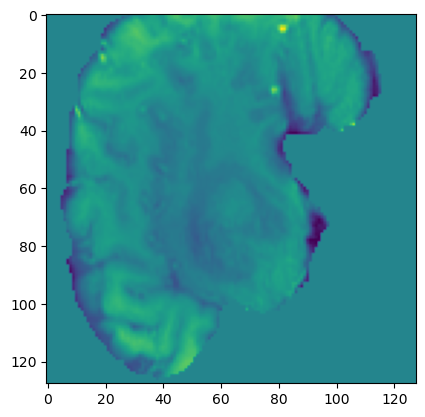

In [234]:
plt.imshow(img[1,0,64,...])

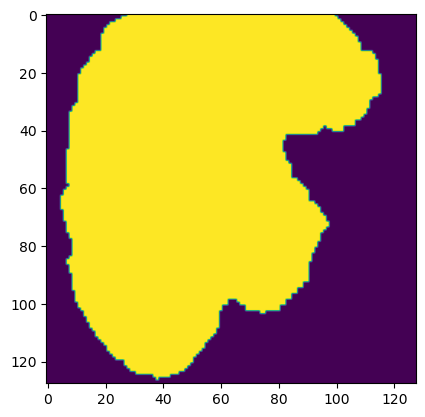

In [232]:
plt.imshow(frg[1,0,64,...])

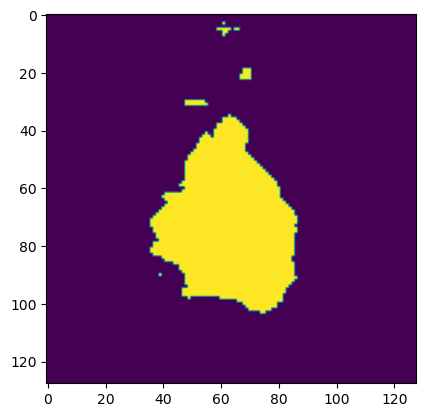

In [233]:
plt.imshow(seg[1,0,64,...])

In [12]:
def trial(patchsize: tuple = (96, 96, 96), epochs=20, continue_training=0):
    """Given a patch size do the experiment for set epochs
    and record the metric in each case.

    Args:
        patchsize (tuple, optional): Input Slice. Defaults to (96,96,96).
    """

    clear_gpu_cache()

    device = torch.device("cuda:0") if torch.cuda.is_available() else "cpu"

    val_interval = 2

    model = UNet(
        spatial_dims=3,
        in_channels=4,
        out_channels=3,
        strides=(2, 2, 2),
        channels=[16,32,64,128],
        num_res_units=2,
    ).to(device)

    optimizer = Novograd(model.parameters(), weight_decay=0.0001)

    scaler = torch.cuda.amp.GradScaler()

    lr_scheduler = WarmupCosineSchedule(
        optimizer,
        warmup_steps=int(epochs / 10),
        warmup_multiplier=1e-10,
        t_total=epochs,
    )

    scheduler_reduce_on_plat = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="max", factor=0.1, patience=20, threshold=0.01
    )

    loss_function = DiceCELoss(sigmoid=True, squared_pred=True)
    # loss_function = DiceFocalLoss(sigmoid=True, squared_pred=True)
    # loss_function = GeneralizedDiceFocalLoss(sigmoid=True)

    # try:
    #     chk = torch.load("./Patch_Size_Experiment_Results/Low_Learning_Rate/Best_Metric_PatchSize_(120, 120, 120).pth")
    #     model.load_state_dict(chk['model'])
    #     optimizer.load_state_dict(chk['optimiser'])
    # except Exception as e:
    #     print(e)

    # ? Check inferer parameters and tweak
    def inference(input):
        """Do Sliding Window Inference on input tensor
        To avoid OOM Error, Input Model done on CPU.
        Patch taken from input and its inference done on GPU
        to speed up inference time.

        Args:
            input: Full input to pass in the model. For the case
            of this project size => (3,240,240,155)
        """

        def _compute(input):
            return sliding_window_inference(
                inputs=input.to("cpu"),
                roi_size=patchsize,
                sw_batch_size=1,
                predictor=model,
                overlap=0.5,
                padding_mode="constant",
                sw_device="cuda:0",
                device="cpu",
                mode="constant",
            )

        with torch.cuda.amp.autocast():
            return _compute(input)

    post_processing_validation = Compose(
        [Activations(sigmoid=True), AsDiscrete(threshold=0.5)]
    )

    dice_metric = DiceMetric(include_background=True, reduction="mean")
    dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

    # transform_training_dataset = Compose(
    #     [
    #         LoadImaged(keys=["image", "seg"]),
    #         EnsureChannelFirstd(keys=["image"]),
    #         CalculateForeground(keys=["image"]),
    #         ConvertLabelsIntoOneHotd(keys="seg"),
    #         ToMetaTensord(["image", "seg", "foreground"]),
    #         Orientationd(keys=["image", "seg", "foreground"], axcodes="RAS"),
    #         NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    #         RandCropByPosNegLabeld(
    #             keys=["image", "seg", "foreground"],
    #             spatial_size=(128, 128, 128),
    #             label_key="seg",
    #             neg=0,
    #             num_samples=2,
    #         ),
    #         RandFlipd(keys=["image", "seg", "foreground"], prob=0.5, spatial_axis=0),
    #         RandFlipd(keys=["image", "seg", "foreground"], prob=0.5, spatial_axis=1),
    #         RandFlipd(keys=["image", "seg", "foreground"], prob=0.5, spatial_axis=2),
    #         RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
    #         RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
    #     ]
    # )
    transform_training_dataset = Compose(
        [
            LoadImaged(keys=["image", "seg"]),
            EnsureChannelFirstd(keys=["image"]),
            ConvertLabelsIntoOneHotd(keys="seg"),
            ToMetaTensord(["image", "seg"]),
            Orientationd(keys=["image", "seg"], axcodes="RAS"),
            NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
            RandCropByPosNegLabeld(
                keys=["image", "seg"],
                spatial_size=(128, 128, 128),
                label_key="seg",
                neg=0,
                num_samples=2,
            ),
            RandFlipd(keys=["image", "seg"], prob=0.5, spatial_axis=0),
            RandFlipd(keys=["image", "seg"], prob=0.5, spatial_axis=1),
            RandFlipd(keys=["image", "seg"], prob=0.5, spatial_axis=2),
            RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
            RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
        ]
    )

    train_data_loader = DataLoader(
        PersistentDataset(
            train_cases,
            transform_training_dataset,
            cache_dir='./cache_patch_experiment/'
        ),
        shuffle=True,
        batch_size=2,
    )

    best_metric = -1

    for epoch in range(continue_training, epochs):
        model.train()
        epoch_loss = 0
        step = 0

        logger.add_scalar("Learning_Rate", optimizer.param_groups[0]["lr"], epoch)

        for batch_data in tqdm(train_data_loader):

            inputs, labels = (
                batch_data["image"].to(device),
                # torch.concat(
                #     [
                #         batch_data["image"].to(device),
                #         batch_data["foreground"].to(device),
                #     ],
                #     dim=1,
                # ),
                batch_data["seg"].to(device),
            )

            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = loss_function(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            step += 1
            epoch_loss += loss.item()

        epoch_loss_value = epoch_loss / step

        lr_scheduler.step()

        logger.add_scalar("Training/Loss", epoch_loss_value, epoch)

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                for val_data in tqdm(val_data_loader):
                    val_inputs, val_labels = (
                        val_data["image"],
                        # torch.concat(
                        #     [val_data["image"], val_data["foreground"]], dim=1
                        # ),
                        val_data["seg"].to(device),
                    )

                    val_outputs = inference(val_inputs)

                    val_outputs = [
                        post_processing_validation(i)
                        for i in decollate_batch(val_outputs.to(device))
                    ]
                    dice_metric(y_pred=val_outputs, y=val_labels)
                    dice_metric_batch(y_pred=val_outputs, y=val_labels)

                metric = dice_metric.aggregate().item()

                scheduler_reduce_on_plat.step(metric)

                metric_batch = dice_metric_batch.aggregate()
                metric_wt = metric_batch[0].item()
                metric_tc = metric_batch[1].item()
                metric_et = metric_batch[2].item()

                if metric > best_metric:
                    best_metric = metric
                    torch.save(
                        {
                            "model": model.state_dict(),
                            "optimiser": optimizer.state_dict(),
                            "scheduler": lr_scheduler.state_dict(),
                            "best_metric_epoch": epoch,
                            "best_metric": best_metric
                        },
                        f"./Patch_Size_Experiment_Results/best_metric_dyn_unet_dicece_2res_chan128div3_const_sliding.pth",
                    )

                logger.add_scalar("DICE/Average", metric, epoch)
                logger.add_scalar("DICE/WT", metric_wt, epoch)
                logger.add_scalar("DICE/TC", metric_tc, epoch)
                logger.add_scalar("DICE/ET", metric_et, epoch)

                dice_metric.reset()
                dice_metric_batch.reset()


In [13]:
patchsizes = [
    # (96,96,96),
    # (80,80,80),
    (128,128,128),
    # (160,160,160),
    # (200,200,200)
]

for patchsize in patchsizes:
    try:
        trial(patchsize,epochs=100)
    except Exception as e:
        print(f"Exception for patch size {patchsize}")
        print(e)

Deleting Model
Model Already Cleared
Clearing CUDA Cache
Done


100%|██████████| 74/74 [03:42<00:00,  3.00s/it]
